Se pide implementar Back Propagation sin utilizar ninguna libreria salvo numpy. 

In [2]:
import numpy as np


#Inicilizar la red con todos los pesos nulos
def red(n_inputs, n_hidden, n_outputs):
	red = []
	hidden_layer = [{'weights':[0 for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	red.append(hidden_layer)
	output_layer = [{'weights':[0 for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	red.append(output_layer)
	return red

La red esta definida como una lista (red) de listas (capas) de diccionarios (neuronas) con el index "weights", a estos diccionarios despues se les agregara el index "epsilon" que seria el error para el backpass.

Es sabido que no es buena idea inicializar la red con estos valores, pero como el utilizar valores aleatorios implicaria ocupar una libreria no permitida, ser hara de todas formas. Por otro lado, lo importante de esta actividad es lado pedagogico, no implementar una verdadera funcion de Back Propagation con fines de aplicacion.

In [3]:
# forwardpass
def forward(red, inputs):
	lista = inputs
	for capa in red:
		new_inputs = []
		for neuron in capa:
			
			act=np.dot(neuron["weights"][0:-1],lista[0:len(neuron["weights"])])+neuron["weights"][-1]#activa
			neuron['output'] = 1.0/(1.0+np.exp(-act)) #sigmoide
			new_inputs.append(neuron['output'])
			
		lista = new_inputs
	return lista


El forwardpass en la practica es la funcion objetivo pasando por todos los pesos, por lo tanto el input es la red con los pesos, y los datos.
Esta funcion esta definida por neurona como el funcional lineal definido por los pesos de las neuronas anteriores y subsequente no linealidad, en este caso una sigmoide. 

In [ ]:
# Backward pass
def backward(network, expected):
	for i in reversed(range(len(network))):
		capa = network[i]
		errores = []
		if i != len(network)-1:#si la capa no es la ultima

			for j in range(len(capa)):
				error = 0.0
				for neuron in network[i + 1]:
					
					error += (neuron['weights'][j] * neuron['epsilon'])
				errores.append(error)
		else:
			
			for j in range(len(capa)):
				errores.append(expected[j] - capa[j]['output'])
		
		for j in range(len(capa)):
			derivada=capa[j]['output']*(1.0-capa[j]['output'])#derivada de la sigmoide
			capa[j]['epsilon'] = errores[j] * derivada #se guarda el error en la neurona


El Backward Pass es la transferencia del error desde la ultima neurona hacia la primera. Esta implementada por capa, si es la ulita el error es tan solo la diferencia del valor esperado con el obtenido, si no es la ultima, se suma por componente el de la neurona siguiente por su peso y la derivada de la sigmoide. Ya que se trabaja sobre los pesos y se necesitan los valores esperados, los inputs es la red y la lista con las etiquetas.

In [18]:
# Entrenamiento
def train(network, train_data, indices, l_rate, n_epoch, n_outputs,listaerror):
	for epoch in range(n_epoch):
		suma_error = 0
		for row in train_data:
			h=0
			outputs = forward(network, row)##feedforward
			expected=[0 for i in range(n_outputs)]
			expected[indices[h]-1]=1#bias
			suma_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])##error cuadratico
			backward(network, expected)##backpropagation
            
            
			for i in range(len(network)):#se recorren las capas
				inputs = row[:-1]
				if i != 0:
					inputs = [neuron['output'] for neuron in network[i - 1]]
				for neuron in network[i]:
					for j in range(len(inputs)):
						neuron['weights'][j] += l_rate * neuron['epsilon'] * inputs[j] #stochastic
					neuron['weights'][-1] += l_rate * neuron['epsilon']                #gradient descent
			h=h+1
		listaerror.append(suma_error)
		
		print('>epoch=%d,error=%.3f' % (epoch,suma_error))		
		

El entrenamiento esta definido por epoch, donde se utiliza los datos y se evaluan con feedforward. Luego, se actualizan los errores hacia atras con backpropagation. Por ultimo, se actualizan los pesos con SGD y se guarda el error.

Los inputs son, la red para actualizar los pesos, la data de entrenamiento como input para feedforward, las etiquetas para comparar resultados, el learning rate para el sgd, el numero de epochs, la dimension del vector de salida y una lista vacia en la que se guardaran los errores.

In [4]:
#entrenamiento con weight decay
def traindecay(network, train_data, indices, l_rate,w_decay, n_epoch, n_outputs,listaerror):
	for epoch in range(n_epoch):
		suma_error = 0
		for row in train_data:
			h=0
			outputs = forward(network, row)
			expected=[0 for i in range(n_outputs)]
			expected[indices[h]-1]=1
			suma_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward(network, expected)
			for i in range(len(network)):
				inputs = row[:-1]
				if i != 0:
					inputs = [neuron['output'] for neuron in network[i - 1]]
				for neuron in network[i]:
					for j in range(len(inputs)):
						neuron['weights'][j] += l_rate * neuron['epsilon'] * inputs[j] + w_decay*l_rate*neuron['weights'][j]
					neuron['weights'][-1] += l_rate * neuron['epsilon']+w_decay*l_rate*neuron['weights'][-1]
			h=h+1                                    #el SGD se actualizo con el weight decay
		listaerror.append(suma_error)

		print('>epoch=%d,error=%.3f' % (epoch,suma_error))	

La implementacion de este metodo es identico al caso anterior salvo la parte del SGD donde se le resta el termino que varia al peso. La ventaja del weight decay es que evita el overfiting penalizando grandes valores de pesos.

>epoch=0,error=12.079
>epoch=1,error=1.062
>epoch=2,error=0.567
>epoch=3,error=0.382
>epoch=4,error=0.286
>epoch=5,error=0.228
>epoch=6,error=0.189
>epoch=7,error=0.161
>epoch=8,error=0.140
>epoch=9,error=0.124
[12.078507559974424, 1.0615827565110394, 0.56712181766212033, 0.382376302054246, 0.2864456295188671, 0.22802065796684648, 0.18885224390116817, 0.16084260786352728, 0.13985933219329827, 0.12357769433845449]


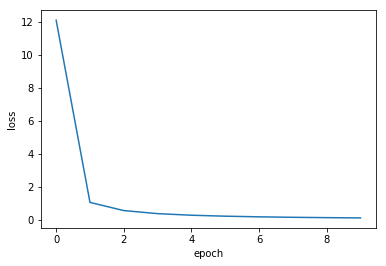

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random 
df=pd.read_csv("seeds.txt", sep='\t', index_col=7)
data= df.values.tolist()


indices=df.index.tolist()
scaler=StandardScaler().fit(data)
data=scaler.transform(data)
n_inputs = len(data[0])
n_hidden=3
n_outputs = 3

network = red(n_inputs, n_hidden, n_outputs)
lr=0.5
n_epochs=10
err=[]
train(network, data,indices, lr, n_epochs, n_outputs,err)
print(err)
plt.plot(err)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


>epoch=0,error=11.728
>epoch=1,error=0.662
>epoch=2,error=0.204
>epoch=3,error=0.068
>epoch=4,error=0.021
>epoch=5,error=0.006
>epoch=6,error=0.001
>epoch=7,error=0.000
>epoch=8,error=0.000
>epoch=9,error=0.000
[11.72776800533099, 0.66249107412473018, 0.20386233355870653, 0.067975994689272234, 0.02124752115244959, 0.0058637026430002253, 0.0013790295556345474, 0.00026905145326565154, 4.2476479611572528e-05, 5.2887672930891408e-06]


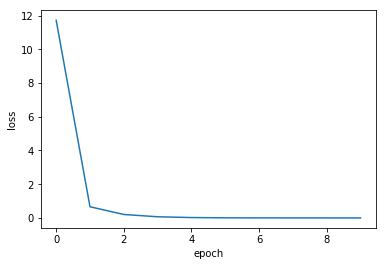

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import funciones as fun
from sklearn.preprocessing import StandardScaler
import random 
df=pd.read_csv("seeds.txt", sep='\t', index_col=7)
data= df.values.tolist()

indices=df.index.tolist()
scaler=StandardScaler().fit(data)
data=scaler.transform(data)
n_inputs = len(data[0])
n_hidden=3
n_outputs = 3

network = red(n_inputs, n_hidden, n_outputs)
lr=0.5
decay=0.001
n_epochs=10
err=[]
traindecay(network, data,indices, lr,decay, n_epochs, n_outputs,err)
print(err)
plt.plot(err)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


Con "Weight Decay" se observa una mejora en la convergencia, eso si, esto no queda claro en el grafico, pero si uno observa los valores se nota que llega antes a ser 0 en la milesima.